# Telco Customer Churn Prediction - Model Training & Evaluation

## 1.0 Introduction

This notebook focuses on training various machine learning classification models to predict customer churn, evaluating their performance, and optimizing them through hyperparameter tuning. We will use the preprocessed and split dataset generated in `2.0-FeatureEngineering-Preprocessing.ipynb`. The goal is to establish optimal model performance and identify the best-performing model for this binary classification problem within the defined project scope.


## 2.0 Load Processed Data

* **Objective:** Load the `X_train`, `X_test`, `y_train`, and `y_test` NumPy arrays that were saved after preprocessing and splitting the data.


In [19]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore') # Suppress warnings for cleaner output

loaded_data = np.load('../data/processed/telco_churn_processed_data.npz')
X_train = loaded_data['X_train']
X_test = loaded_data['X_test']
y_train = loaded_data['y_train']
y_test = loaded_data['y_test']

print("Data loaded successfully!")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


Data loaded successfully!
X_train shape: (5625, 30)
X_test shape: (1407, 30)
y_train shape: (5625,)
y_test shape: (1407,)


## 3.0 Utility Functions for Evaluation
* **Objective:** Define reusable functions to streamline  model evaluation. These functions will print key metrics, visualize the confusion matrix and plot the Receiver Operating Characteristic (ROC) curve for each training model. This modular approach improves code readability and reduces repetition.
### 3.1 `print_metrics` Function
This function takes true labels and predicted labels and probabilities to calcuate and print common classification metrics.
### 3.2 `plot_confusion_matrix` Function
This function visualizes the confusion matrix, providing a clear breakdown of True Positives, True Negatives, False Positives, and False Negatives.
### 3.3 `plot_roc_curve` Function
This function plots the ROC curve, which illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. The Area Under the Curve (AUC) provides a single value summary of classifier performance.

In [21]:
def print_metrics(y_pred, y_prob=None, model_name='Model'):
    print(f'---- {model_name} Evaluation ----')
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1-Score:", f1_score(y_test, y_pred))
    if y_prob is not None:
        print("ROC AUC Score:", roc_auc_score(y_test, y_prob))


In [22]:
def plot_confusion_matrix(y_pred, title):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, \
                xticklabels=['Predicted No Churn', 'Predicted Churn'], \
                yticklabels=['Actual No Churn', 'Actual Churn'])
    plt.title(f'{title} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [66]:
def plot_roc_curve(y_prob, title):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{title} (AUC = {roc_auc_score(y_test, y_prob):.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='(AUC = 0.50)')
    plt.title(f'ROC Curve for {title}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

## 4.0 Model Training and Evaluation
* **Objective:** Train initial versions of chosen classification models without extensive hyperparameter tuning to establish a baseline performance. We are using `class_weight='balanced'` in our initial models to address the class imbalance observed during EDA.

### 4.1 Logistic Regression
* Logistic Regression is a linear model used for binary classification. It is a classification algorithm that estimates the probability of a binary otucome. It serves as a good baseline model due to its simplicity and interpretability.
* Parameters `random_state=42` ensures reproducibility. `solver='liblinear` is a good default for smaller datasets and handles L1/L2 regularization. `class_weight='balanced'` automatically adjusts weights inversely proportional to class frequencies, giving more importance to churners.

In [25]:
logreg = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced')
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)
y_proba_lr = logreg.predict_proba(X_test)[:, 1]
print_metrics(y_pred_lr, y_proba_lr, 'Logistic Regression')

---- Logistic Regression Evaluation ----
Accuracy: 0.7249466950959488
Precision: 0.48929159802306427
Recall: 0.7941176470588235
F1-Score: 0.6055045871559633
ROC AUC Score: 0.8353984293708683


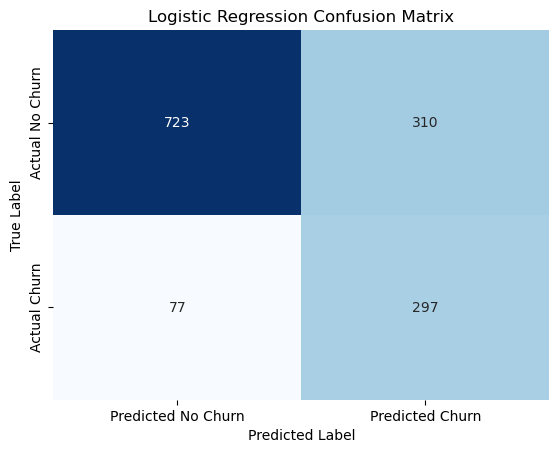

In [26]:
plot_confusion_matrix(y_pred_lr, 'Logistic Regression')


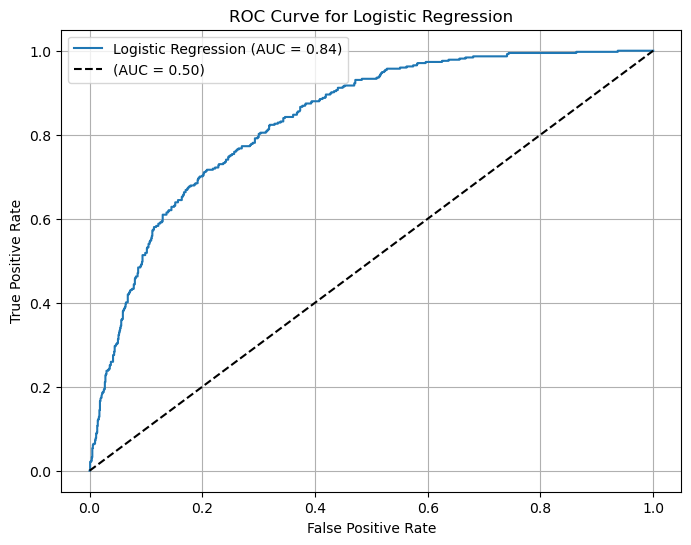

In [68]:
#plot roc curve
plot_roc_curve(y_proba_lr, 'Logistic Regression')

### 4.2 Random Forest Classifier
* Random Forest is an ensemble learning method that constructs a multitude of decision trees during training and outputs the mode of the classes (for classification) of the individual trees. Known for its high accuracy and robustness against  overfitting.
* Parameters `random_state=42` ensures reproducibility. `n_estimators=100` means 100 decision trees are built. `class_weight=balanced` is used to handle class imbalance, similar to Logistic Regression.

In [29]:
#Train second model Random Forest Classifier
rf = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

In [75]:
print_metrics(y_pred_rf, y_prob_rf, 'Random Forest')

---- Random Forest Evaluation ----
Accuracy: 0.7874911158493249
Precision: 0.6288659793814433
Recall: 0.4893048128342246
F1-Score: 0.5503759398496241
ROC AUC Score: 0.817818150757619


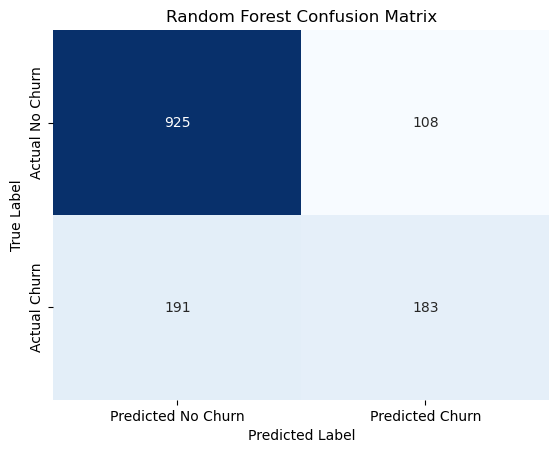

In [31]:
plot_confusion_matrix(y_pred_rf, 'Random Forest')

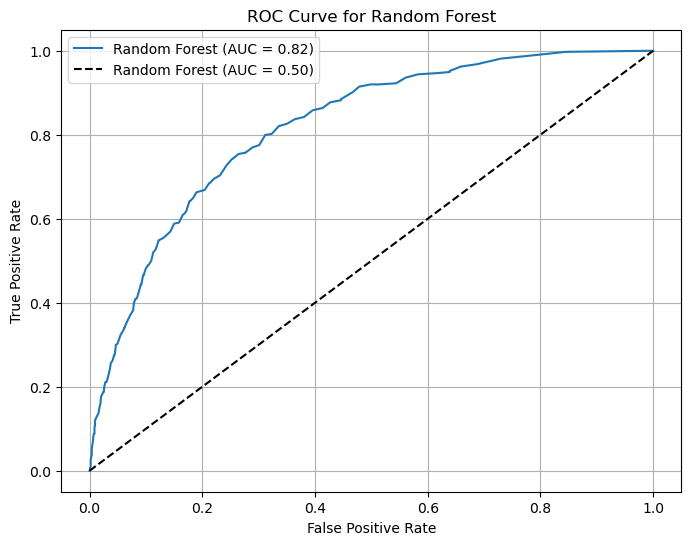

In [32]:
plot_roc_curve(y_prob_rf, 'Random Forest')

## 5.0 Conclusion and Initial Model Comparison.
* **Objective:** Compare the performance of Logistic Regression and Random Forest Classifier based on the calculated metrics, and derive initial insights into which model characteristics might be more suitable for the churn prediction.

### 5.1 Summary of Modal Performace
| Metric | Logistic Regression | Random Forest | Comments
| :-------- | :--------: | :--------:|:---------|
| **Accuracy** | 0.7249 | 0.7875 | Random Forest Classifier achieved a higher overall accuracy. However accuracy can be misleading in imbalanced datasets.
| **Precision** | 0.4893 | 0.6289 | Random Forest shows higher Precision. This means that when it predicts a customer will churn, it is correct about 62% of the time. This leads to fewer "false alarms" (customers incorrectly identified as churners). Logistic Regression had lower precision meaning more non-churners are mistakenly flagged as churners.
| **Recall** | 0.7941 | 0.4893 | Logistic Regression excels in Recall. It identified 79.4% of all actual churners in the test set. This is often a critical metric in churn prediction, as identifying more potential churners allows for targeted retention efforts. Random Forest has lower recall (48.9%), meaning it missed large proportion of actual churners.
| **F1-Score** | 0.6055 | 0.5504 | Logistic Regression has a slightly higher F1-Score indicating a better balance between precision and recall for this threshold
| **ROC AUC Score** | 0.8354 | 0.8178 | Logistic Regression has a slightly higher ROC AUC Score than Random Forest, suggesting Logistic Regression is slightly better at distinguishing between churners and non-churners across various classification thresholds. 
* **Impact of** `class-weight='balanced'`: Both models were trained with balanced class-weight. This parameter is effective in addressing the class imbalance by giving more weight to the minority class during training, churners in this case. This typically lead to improved recall for the minority class, oftern at the cost of some precision for the majority class, which was observed particularly with Logistic Regression.

### 5.2 Conclusion & Trade-offs
* If the primary business objective is to **identify as many actual churners as possible** (high recall) to intervene with retention strategies, **Logistic Regression** appears to be more suitable model so far, despite of its lower precision. The higher recall means fewer missed opportunities for intervention.
* If the objective is to be **very accurate when predicting churn** (high precision) to avoid wasting resorces on false alarms, **Random Forest** performs better in that regard, but at the cost of missing many actual churners.
* The ROC AUC score suggests that Logistic Regression has a slightly better overall ability to rank churners higher than non-churners.


## 6.0 Hyperparamter Tuning
* **Objective:** Optimize the performance of the selected models by searching for the best combination of hyperparameters. The aim is to maximize the models ability to generalize to unseen data, typically by improving a chosen scoring metric.

### 6.1 Hyperparameter Tuning for LogisticRegression
* **Method:** `GridSearchCV` is used to exhaustively search over a predefined grid of hyperparameters.
* **Parameters being tuned:**
  * `C`: Inverse of regularization strength, smaller values specify stronger regularization. This helps prevernt overfitting
  * `penalty`: The norm used in the penalization(`l1` for Lasso, `l2 for Ridge).`liblinear` solver supports both.
* **Evaluation Metric:** `scoring='roc_auc'` is chosen to optimize for the models ability to distinguish between classes, which is robust for imbalanced datasets. 

In [35]:
log_reg_tuned = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced')
param_grid_lr = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 
                 'penalty': ['l1', 'l2']}
#set up GridSearchCV with 5-fold cross-validation. 
grid_search_lr = GridSearchCV(estimator=log_reg_tuned, \
                          param_grid=param_grid_lr, \
                              cv=5, scoring='roc_auc', \
                          verbose=1, n_jobs=-1)
grid_search_lr.fit(X_train, y_train)
print(f'Best Params for Logistic Regression: {grid_search_lr.best_params_}')
print(f'Best cross-validation ROC AUC score for Logistic Regression: {grid_search_lr.best_score_:.4f}')

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Params for Logistic Regression: {'C': 100, 'penalty': 'l2'}
Best cross-validation ROC AUC score for Logistic Regression: 0.8458


In [36]:
#get best model using best_estimator_
best_lr_model = grid_search_lr.best_estimator_
#evaluate best model on test set
y_pred_best_lr = best_lr_model.predict(X_test)
y_prob_best_lr = best_lr_model.predict_proba(X_test)[:, 1]

print_metrics(y_pred_best_lr, y_prob_best_lr, 'Logistic Regression Tuned')


---- Logistic Regression Tuned Evaluation ----
Accuracy: 0.7256574271499645
Precision: 0.4901639344262295
Recall: 0.7994652406417112
F1-Score: 0.6077235772357723
ROC AUC Score: 0.8342129512193859


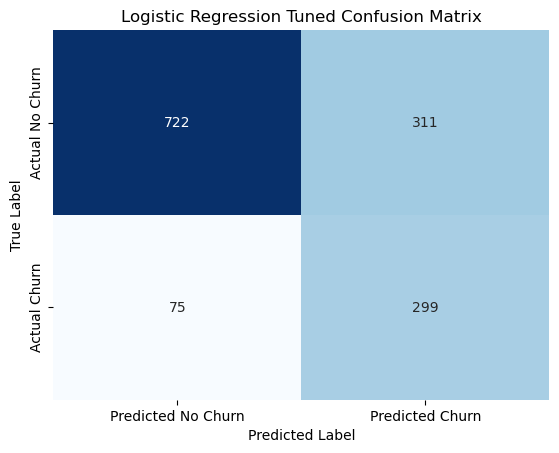

In [37]:
plot_confusion_matrix(y_pred_best_lr, 'Logistic Regression Tuned')

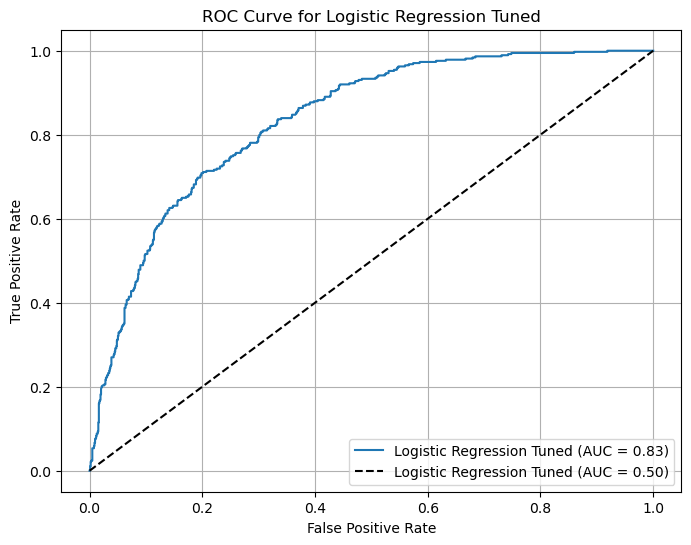

In [38]:
plot_roc_curve(y_prob_best_lr, 'Logistic Regression Tuned')

### 6.2 Hyperparameter tuning for Random Forest Classifier
* **Method:** `RandomizedSearchCV` is used to sample a fixed number of parameter settings from specified distributions. This is more efficient than `GridSearchCV` for models with many hyperparameters and a large search space, as it typically finds a good set of hyperparameters much faster.
* **Parameters being tuned:**
  * `n_estimators`: Number of trees in the forest.
  * `max_features`: Number of features to consider when looking for the best split.
  * `max_depth`: Maximum depth of the tree.
  * `min_samples_split`: Minimum number of samples required to split an internal node.
  * `min_samples_leaf`: Minimum number of samples required to be at a leaf node.
  * `bootstrap`: Whether bootstrap samples are used when building trees.
* **Evaluation Metric:** `scoring='roc_auc'` is used for optimization.

In [40]:
rf_tuned = RandomForestClassifier(random_state = 42, class_weight='balanced')
#define param grid
params_grid_rf = {
    'n_estimators': [50, 100, 200, 300], 
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [10, 20, 30, None], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4], 
    'bootstrap':[True, False]            
    }
#set up RandomizedSearchCV with 50 random combinations and 5-fold cross-validation
random_search_rf = RandomizedSearchCV(estimator = rf_tuned, \
                    param_distributions=params_grid_rf, \
                    n_iter=50, cv = 5, scoring='roc_auc', \
                    random_state=42, verbose=1, n_jobs=-1)
#fit to training data
random_search_rf.fit(X_train, y_train)
print(f'Best Params for Random Forest: {random_search_rf.best_params_}')
print(f'Best cross-validation ROC AUC score for Random Forest: {random_search_rf.best_score_:.4f}')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Params for Random Forest: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': True}
Best cross-validation ROC AUC score for Random Forest: 0.8463


In [60]:
#get best estimator
best_rf_model = random_search_rf.best_estimator_
#evaluate the best model on the test set
y_pred_best_rf = best_rf_model.predict(X_test)
y_prob_best_rf = best_rf_model.predict_proba(X_test)[:, 1]
print_metrics(y_pred_best_rf, y_prob_best_rf, 'Random Forest Classifier Tuned')

---- Random Forest Classifier Tuned Evaluation ----
Accuracy: 0.7562189054726368
Precision: 0.5286506469500925
Recall: 0.7647058823529411
F1-Score: 0.6251366120218579
ROC AUC Score: 0.8374846638470577


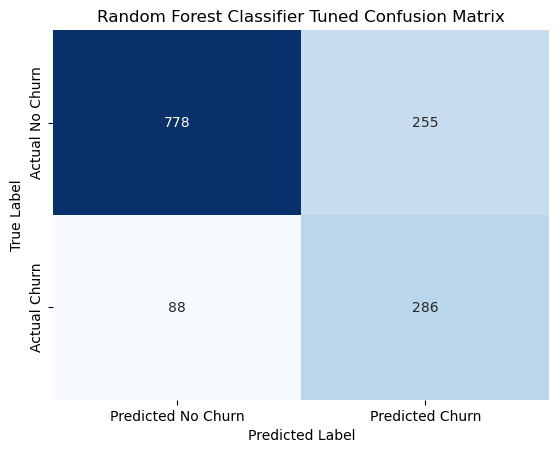

In [62]:
plot_confusion_matrix(y_pred_best_rf, 'Random Forest Classifier Tuned')

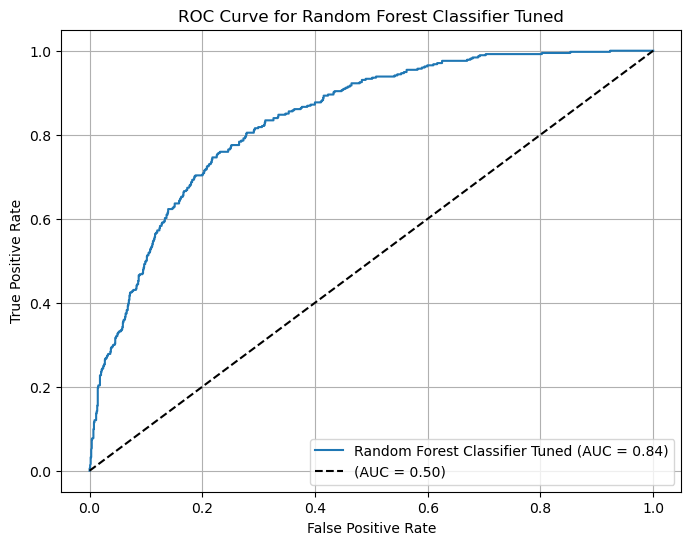

In [70]:
plot_roc_curve(y_prob_best_rf, 'Random Forest Classifier Tuned')

## 7.0 Model Comparision and Conclusion 
* **Objective:** Compare the performace of the tuned Logistic Regression and Random Forest Classifier models, identify the best-performing model based on key metrics for churn prediction, and summarize the overall project findings.
  

### 7.1 Performance Summary Table (Baseline vs Tuned Models).
| Metric | Baseline Logistic Regression |Tuned Logistic Regression | Baseline Random Forest | Tuned Random Forest |
| :-------- | :--------: | :--------: | :--------:| :--------:|
| **Accuracy** | 0.7250 | 0.7256 | 0.7874 | 0.7562
| **Precision** | 0.4893 | 0.4901 | 0.6288 | 0.5286
| **Recall** | 0.7941 | 0.7994 | 0.4893 | 0.7647
| **F1-Score** | 0.6055 | 0.6077 | 0.5503 | 0.6251
| **ROC AUC Score** | 0.8354 | 0.8342 | 0.8178 | 0.8178

### 7.2 Overall Project Findings and Best Model Selection

* **Baseline Model Performance:**
    * **Logistic Regression (Baseline):** Showed a strong recall (0.79) for the churn class, indicating good ability to identify actual churners, but with lower precision (0.48). Its ROC AUC was 0.8354.
    * **Random Forest (Baseline):** Achieved higher accuracy (0.78) and notably higher precision (0.62) than Logistic Regression, but at the cost of significantly lower recall (0.48). Its ROC AUC was 0.81.
    * The initial use of `class_weight='balanced'` for both models was crucial in encouraging them to pay more attention to the minority (churn) class.

* **Impact of Hyperparameter Tuning:**
    * **Logistic Regression (Tuned):** Tuning led to slight improvements across most metrics for Logistic Regression (e.g., Recall increased to 0.7995, Precision to 0.49). The optimal parameters found were `C=100` and `penalty='l2'`. The cross-validation ROC AUC score improved to 0.8458, while the test set ROC AUC remained stable at 0.8342. This indicates that the initial baseline Logistic Regression was already quite robust.
    * **Random Forest (Tuned):** Hyperparameter tuning had a more significant impact on the Random Forest Classifier, particularly in improving its ability to identify churners. While overall accuracy and precision slightly decreased on the test set, its **Recall dramatically increased from 0.4893 to 0.7647**. This is a major improvement for churn prediction. Correspondingly, its F1-Score improved from 0.5504 to 0.6251, and its ROC AUC score increased from 0.8178 to 0.8375. The tuning successfully shifted its focus towards better recall while maintaining a strong overall discriminative performance. The best parameters involved `n_estimators=300`, `max_depth=10`, `min_samples_split=5`, `min_samples_leaf=4`, `max_features='log2'`, and `bootstrap=True`.

* **Best Model Selection:**
    * After tuning, the **Random Forest Classifier** emerges as the best-performing model for this churn prediction task.
    * **Justification:** While the tuned Logistic Regression maintained a high recall, the tuned Random Forest model achieved a significant improvement in its recall (now highly competitive with LR's recall) while also securing the highest F1-Score (0.6251) and the highest ROC AUC Score (0.8375) on the test set. For a churn prediction problem, a high recall is often paramount (to identify as many potential churners as possible), and the Random Forest model now offers a much better balance between precision and recall, along with superior overall discriminative power. Its higher F1-score indicates a more robust balance, and its slightly higher AUC confirms its better ability to rank churners vs. non-churners.
